<a href="https://colab.research.google.com/github/peterchang0414/randomized_priors/blob/main/randomized_priors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Randomized Prior Functions for Deep Reinforcement Learning
Based on Osband et al 2018: https://proceedings.neurips.cc/paper/2018/file/5a7b238ba0f6502e5d6be14424b20ded-Paper.pdf

Adapted to JAX from https://www.kaggle.com/code/gdmarmerola/introduction-to-randomized-prior-functions/notebook

Author: Peter G. Chang ([@peterchang0414](https://github.com/peterchang0414))

# 0. Imports

In [101]:
!pip -q install flax

In [102]:
%matplotlib inline

from functools import partial
import matplotlib.pyplot as plt

import optax
import jax
import jax.numpy as jnp
from jax.nn.initializers import glorot_normal

import flax
import flax.linen as nn
from flax.training import train_state

# 1. Simple Example

Generate dataset [using](https://arxiv.org/pdf/1505.05424.pdf):
$$
y = x + 0.3 \sin(2 \pi(x + \epsilon)) + 0.3 \sin(4 \pi(x + \epsilon)) + \epsilon
$$
where $\epsilon \sim \mathcal{N}(0, 0.02)$ and $x \sim \mathcal{U}(0.0, 0.5)$.


In [103]:
# Generate dataset and grid
key, subkey = jax.random.split(jax.random.PRNGKey(0))
X = jax.random.uniform(key, shape=(100, 1), minval=0.0, maxval=0.5)
x_grid = jnp.linspace(-5, 5, 1000).reshape(-1, 1)

# Define function
def target_toy(key, x):
  epsilons = jax.random.normal(key, shape=(3,))*0.02
  return (x + 0.3*jnp.sin(2*jnp.pi*(x+epsilons[0])) + 
          0.3*jnp.sin(4*jnp.pi*(x+epsilons[1])) + epsilons[2])

# Define vectorized version of function
target_vmap = jax.vmap(target_toy, in_axes=(0, 0), out_axes=0)

# Generate target values
keys = jax.random.split(subkey, X.shape[0])
Y = target_vmap(keys, X)

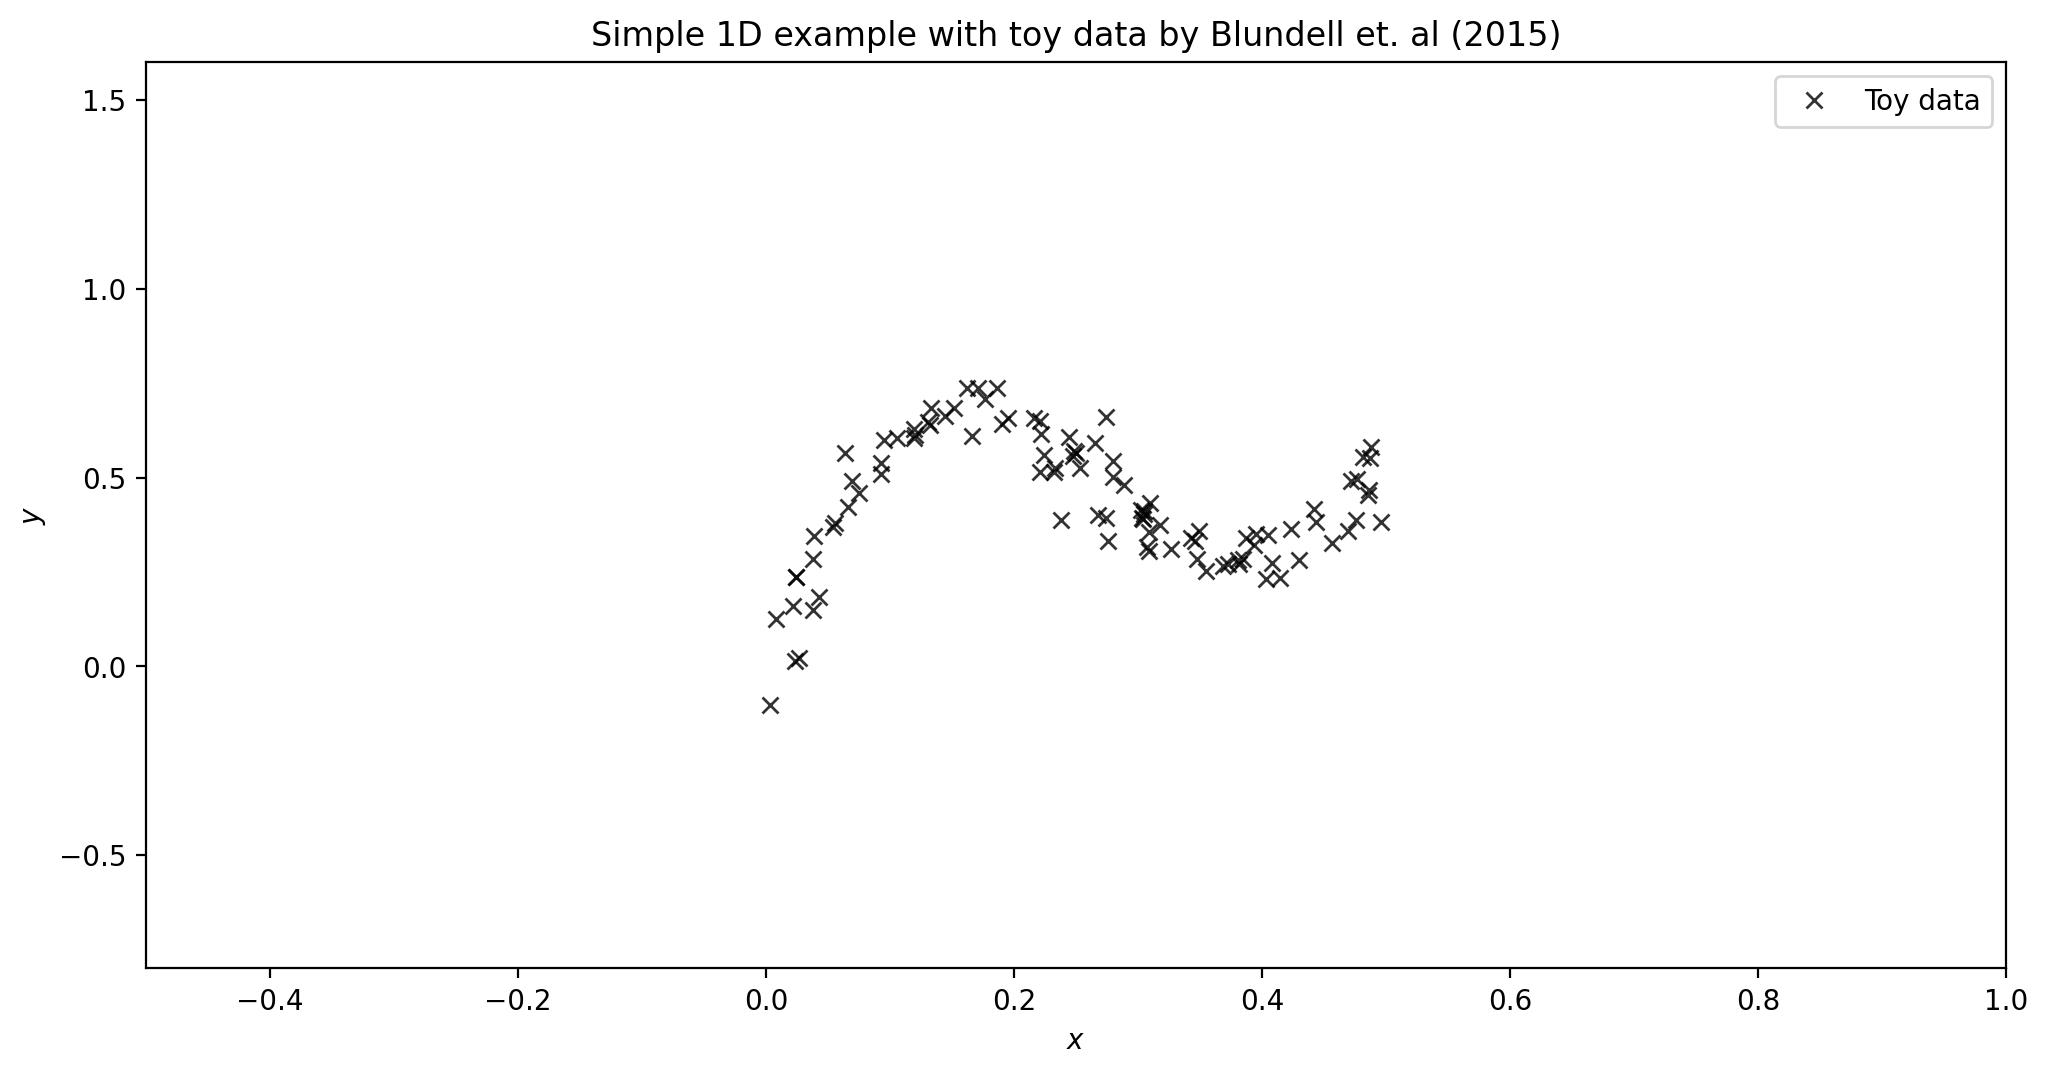

In [104]:
# Plot the generated data
plt.figure(figsize=[12,6], dpi=200)
plt.plot(X, Y, 'kx', label='Toy data', alpha=0.8)
plt.title('Simple 1D example with toy data by Blundell et. al (2015)')
plt.xlabel('$x$'); plt.ylabel('$y$')
plt.xlim(-0.5,1.0); plt.ylim(-0.8,1.6)
plt.legend();
plt.show()

#2. Randomized Prior Functions

In [117]:
# Prior and trainable networks have the same architecture
class GenericNet(nn.Module):
  @nn.compact
  def __call__(self, x):
    dense = partial(nn.Dense, kernel_init=glorot_normal())
    return nn.Sequential([dense(16), nn.elu, dense(16), nn.elu, dense(1)])(x)

# Model that combines prior and trainable nets
class Model(nn.Module):
  prior: GenericNet
  trainable: GenericNet
  beta: int

  @nn.compact
  def __call__(self, x):
    x1 = self.prior(x)
    x2 = self.trainable(x)
    return self.beta*x1 + x2

In [122]:
def create_train_state(key, X, beta):
  key, _ = jax.random.split(key)
  model = Model(prior=GenericNet(), trainable=GenericNet(), beta=beta)
  params = model.init(key, X)['params']
  p_params, t_params = params['prior'], params['trainable']
  opt = optax.adam(learning_rate=0.03)
  return p_params, train_state.TrainState.create(apply_fn=model.apply, 
                                                 params=t_params, tx=opt)

def train_epoch(p_params, train_state, X, Y):
  def loss_fn(params):
    model = Model(prior=GenericNet(), trainable=GenericNet(), beta=3)
    Yhat = model.apply({'params': {'prior': p_params, 'trainable': params}}, X)
    loss = jnp.mean((Yhat - Y)**2)
    return loss
  Yhats, grads = jax.value_and_grad(loss_fn)(train_state.params)
  train_state = train_state.apply_gradients(grads=grads)
  return train_state

def train(key, X, Y, beta, epochs):
  p_params, train_state = create_train_state(key, X, beta)
  for epoch in range(1, epochs + 1):
    train_state = train_epoch(p_params, train_state, X, Y)
  return p_params, train_state.params

In [123]:
p_params, t_params = train(jax.random.PRNGKey(0), X, Y, 3, 100)

In [129]:
model = Model(prior=GenericNet(), trainable=GenericNet(), beta=3)
Yhat = model.apply({'params': {'prior': p_params, 'trainable': t_params}}, X)
# prior = PriorNet()
# trainable = TrainableNet()
# Y_prior = prior.apply({'params': p_params}, x_grid)
# Y_trainable = trainable.apply({'params': t_params}, x_grid)

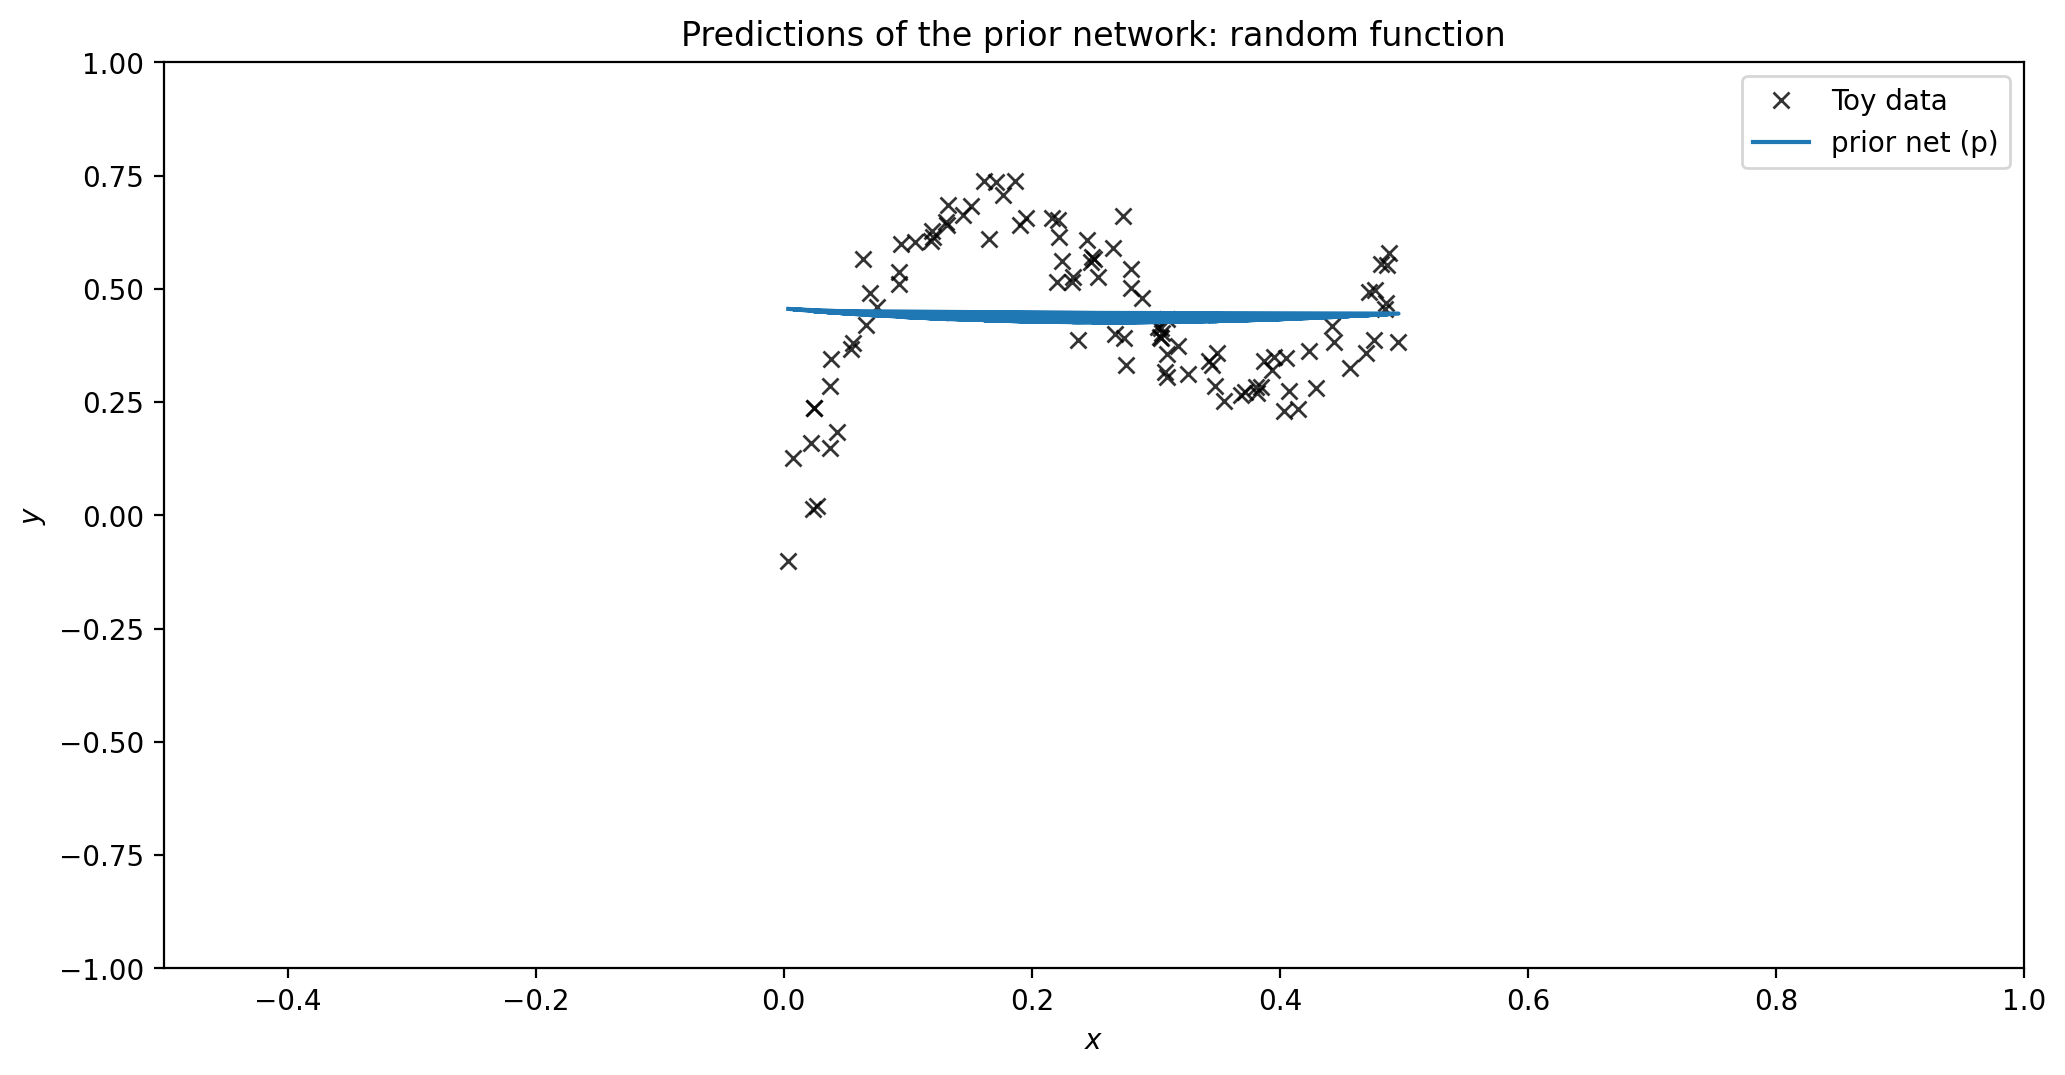

In [131]:
# Plot the randomized prior function
plt.figure(figsize=[12,6], dpi=200)
plt.plot(X, Y, 'kx', label='Toy data', alpha=0.8)
plt.plot(X, Yhat, label='prior net (p)')
plt.title('Predictions of the prior network: random function')
plt.xlabel('$x$'); plt.ylabel('$y$')
plt.xlim(-0.5,1.0); plt.ylim(-1.0,1.0)
plt.legend();
plt.show()

In [121]:
p_params, t_params = train(jax.random.PRNGKey(0), X, Y, 3, 100)

loss = 0.59969562292099
loss = 0.10374267399311066
loss = 0.04993833601474762
loss = 0.14211226999759674
loss = 0.10772045701742172
loss = 0.04519506171345711
loss = 0.04543124884366989
loss = 0.08499309420585632
loss = 0.09366612136363983
loss = 0.0679570883512497
loss = 0.04053011164069176
loss = 0.032982222735881805
loss = 0.04347078129649162
loss = 0.05520828068256378
loss = 0.055532652884721756
loss = 0.04588437080383301
loss = 0.03530574217438698
loss = 0.03057411126792431
loss = 0.03241182863712311
loss = 0.03721233829855919
loss = 0.04062613844871521
loss = 0.04033104330301285
loss = 0.036869168281555176
loss = 0.03277141600847244
loss = 0.030778896063566208
loss = 0.031974028795957565
loss = 0.03472764045000076
loss = 0.03609965369105339
loss = 0.0349639356136322
loss = 0.03262636810541153
loss = 0.031010912731289864
loss = 0.030978001654148102
loss = 0.03202035278081894
loss = 0.03303476795554161
loss = 0.033222492784261703
loss = 0.03250815346837044
loss = 0.0314234569668769

In [106]:
key, _ = jax.random.split(jax.random.PRNGKey(1))

model = PriorNet()
params = model.init(key, x_grid)
prior_preds = 3 * model.apply(params, x_grid)

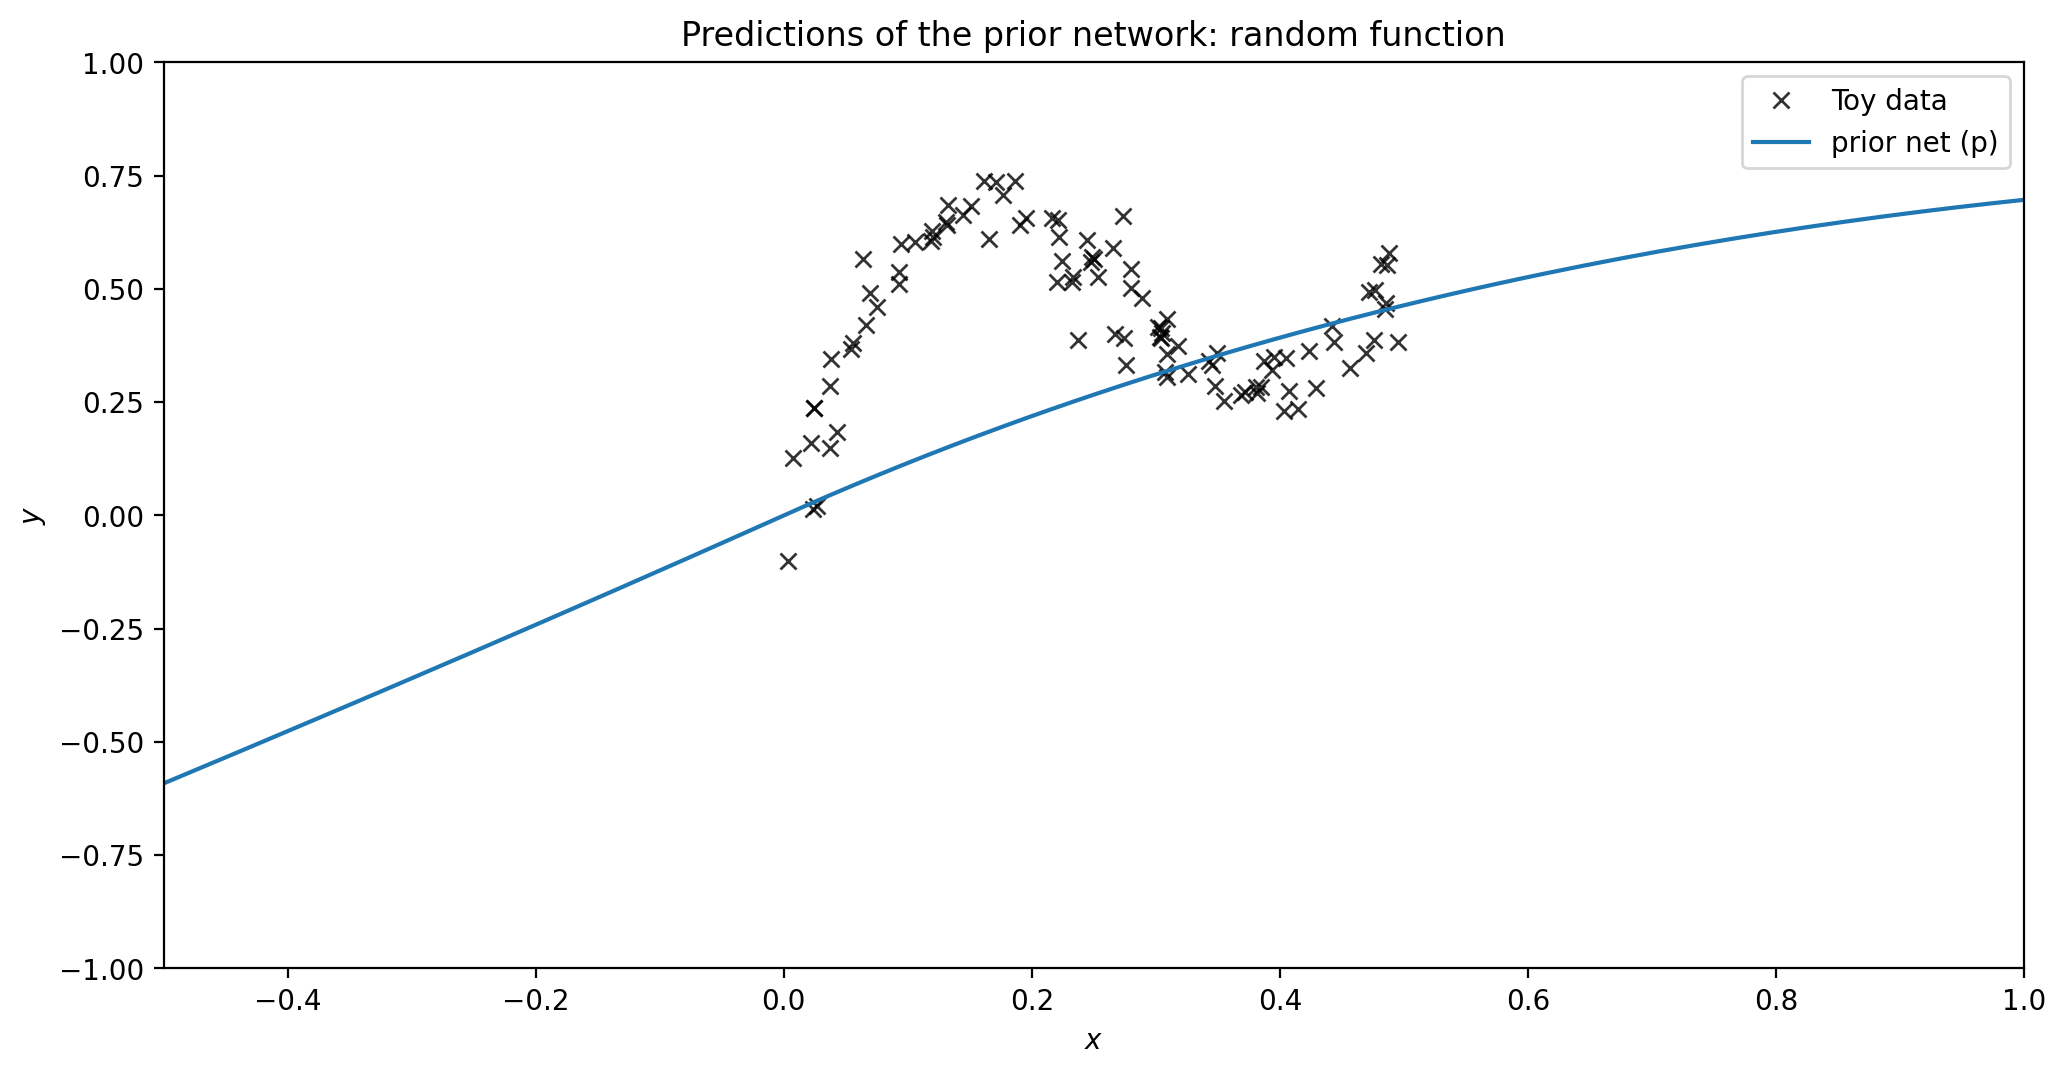

In [107]:
# Plot the randomized prior function
plt.figure(figsize=[12,6], dpi=200)
plt.plot(X, Y, 'kx', label='Toy data', alpha=0.8)
plt.plot(x_grid, prior_preds, label='prior net (p)')
plt.title('Predictions of the prior network: random function')
plt.xlabel('$x$'); plt.ylabel('$y$')
plt.xlim(-0.5,1.0); plt.ylim(-1.0,1.0)
plt.legend();
plt.show()

In [108]:
class TrainableNet(nn.Module):
  @nn.compact
  def __call__(self, x):
    dense = partial(nn.Dense, kernel_init=glorot_normal())
    return nn.Sequential([dense(16), nn.elu, dense(16), nn.elu, dense(1)])(x)

In [109]:
class Model(nn.Module):
  prior: PriorNet
  trainable: TrainableNet
  beta: int

  @nn.compact
  def __call__(self, x):
    x1 = self.prior(x)
    x2 = self.trainable(x)
    return self.beta*x1 + x2

In [110]:
prior = PriorNet()
trainable = TrainableNet()
model = Model(prior = prior, trainable = trainable, beta=3)

init_vars = model.init(jax.random.PRNGKey(0), jnp.zeros((5, 5)))

In [112]:
def create_train_state(key, X, beta):
  key, _ = jax.random.split(key)
  prior = PriorNet()
  trainable = TrainableNet()
  model = Model(prior=prior, trainable=trainable, beta=beta)
  params = model.init(key, X)['params']
  p_params, t_params = params['prior'], params['trainable']
  opt = optax.adam(learning_rate=3e-4)
  return p_params, train_state.TrainState.create(apply_fn=model.apply, 
                                                 params=t_params, tx=opt)

@jax.jit
def train_epoch(p_params, train_state, X, Y):
  def loss_fn(params):
    model = Model(prior = PriorNet(), trainable = TrainableNet(), beta=3)
    Yhat = model.apply({'params': {'prior': p_params, 'trainable': params}}, X)
    loss = jnp.mean((Yhat - Y)**2)
    return loss
  Yhats, grads = jax.value_and_grad(loss_fn)(train_state.params)
  train_state = train_state.apply_gradients(grads=grads)
  return train_state

def train(key, X, Y, beta, epochs):
  p_params, train_state = create_train_state(key, X, beta)
  for epoch in range(1, epochs + 1):
    train_state = train_epoch(p_params, train_state, X, Y)
  return p_params, train_state.params

In [113]:
p_params, t_params = train(jax.random.PRNGKey(0), X, Y, 3, 2000)

In [114]:
model = Model(prior = PriorNet(), trainable = TrainableNet(), beta=3)
Yhat = model.apply({'params': {'prior': p_params, 'trainable': t_params}}, x_grid)
prior = PriorNet()
trainable = TrainableNet()
Y_prior = prior.apply({'params': p_params}, x_grid)
Y_trainable = trainable.apply({'params': t_params}, x_grid)

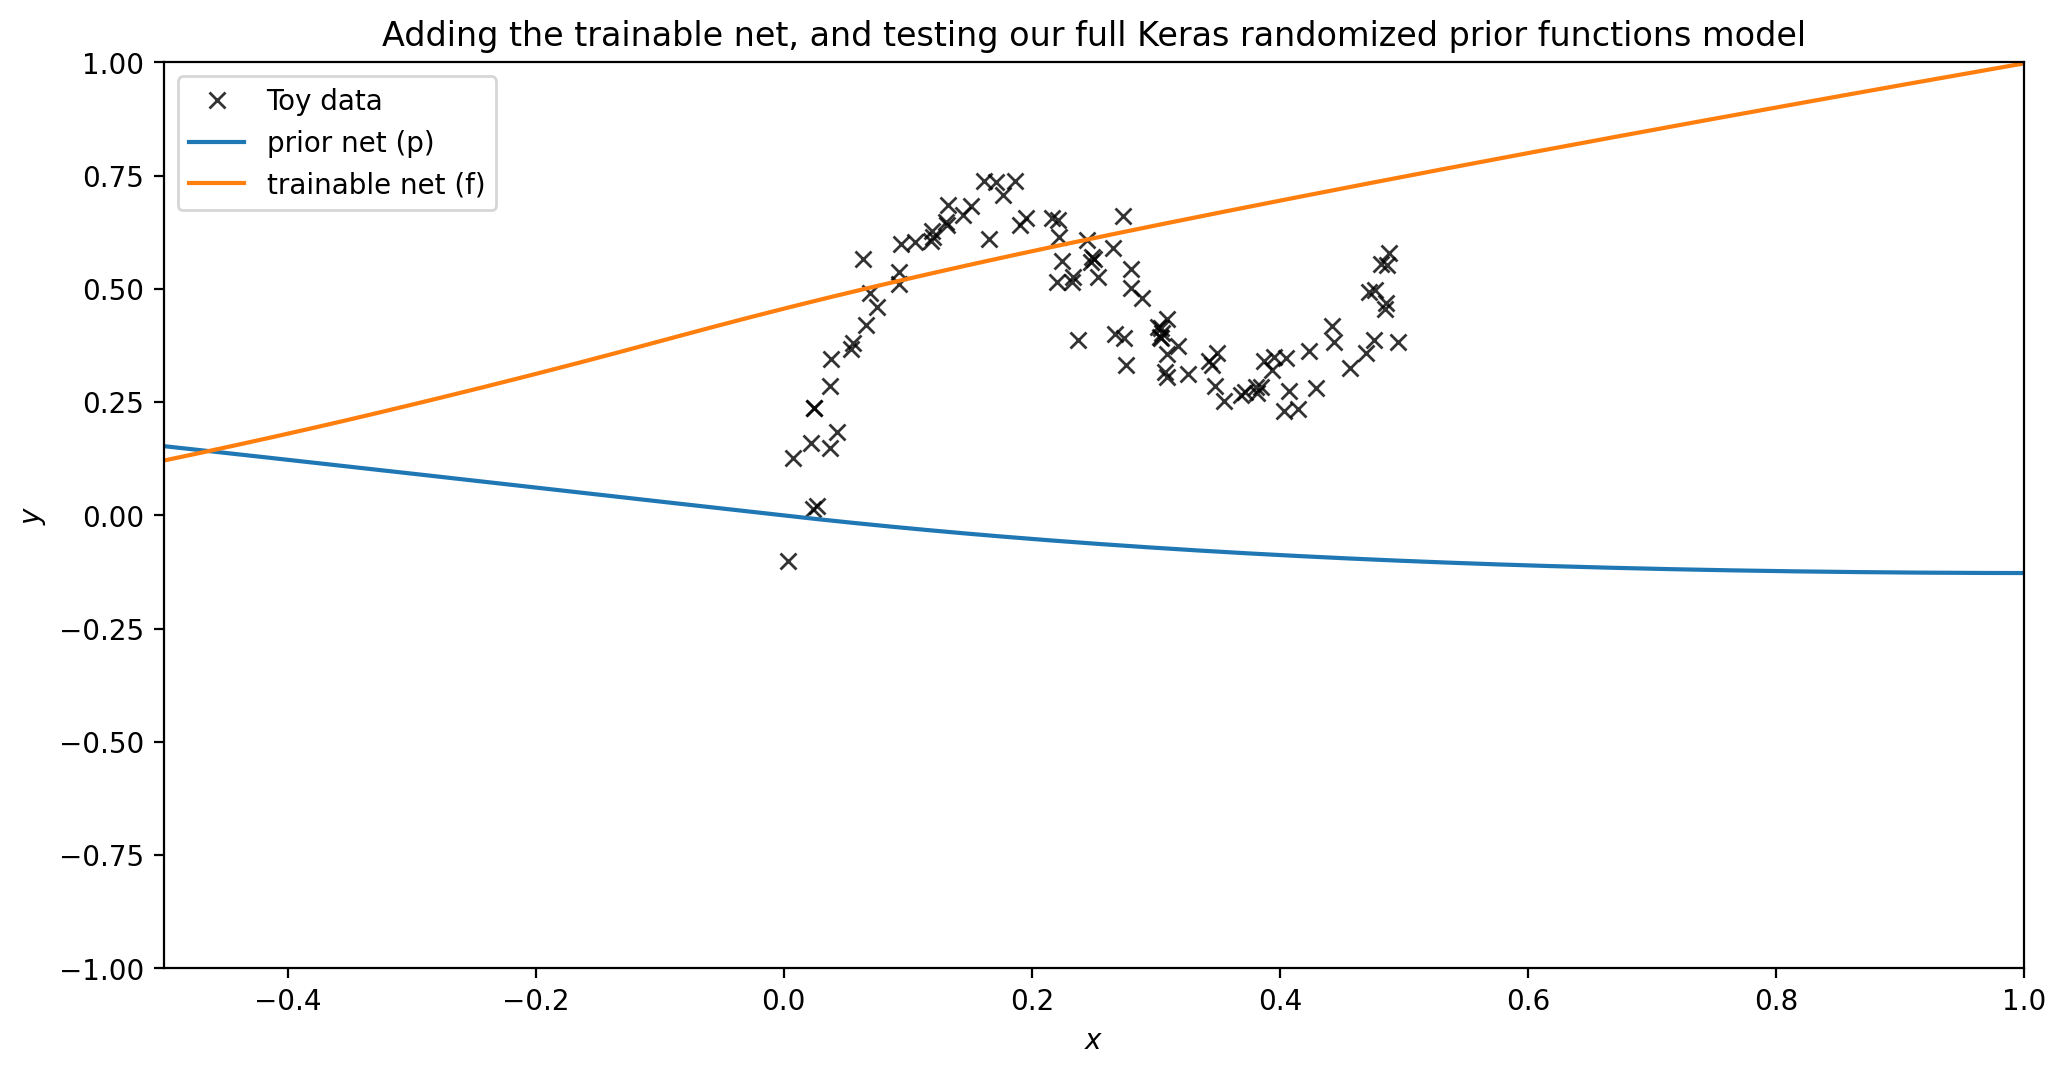

In [115]:
# let us check the toy data
plt.figure(figsize=[12,6], dpi=200)

# first plot
plt.plot(X, Y, 'kx', label='Toy data', alpha=0.8)
plt.plot(x_grid, Y_prior, label='prior net (p)')
plt.plot(x_grid, Y_trainable, label='trainable net (f)')
# plt.plot(x_grid, model.predict(x_grid), label='resultant (Q)')
plt.title('Adding the trainable net, and testing our full Keras randomized prior functions model')
plt.xlabel('$x$'); plt.ylabel('$y$')
plt.xlim(-0.5,1.0); plt.ylim(-1.0,1.0)
plt.legend();
plt.show()

# 3. Bootstrapped Ensembles